In [1]:
import cv2
import subprocess
import re
import numpy as np
import pandas as pd
from PyPDF2 import PdfFileReader
from IPython.display import Image

### PDF to CSV Block Based Algorithm

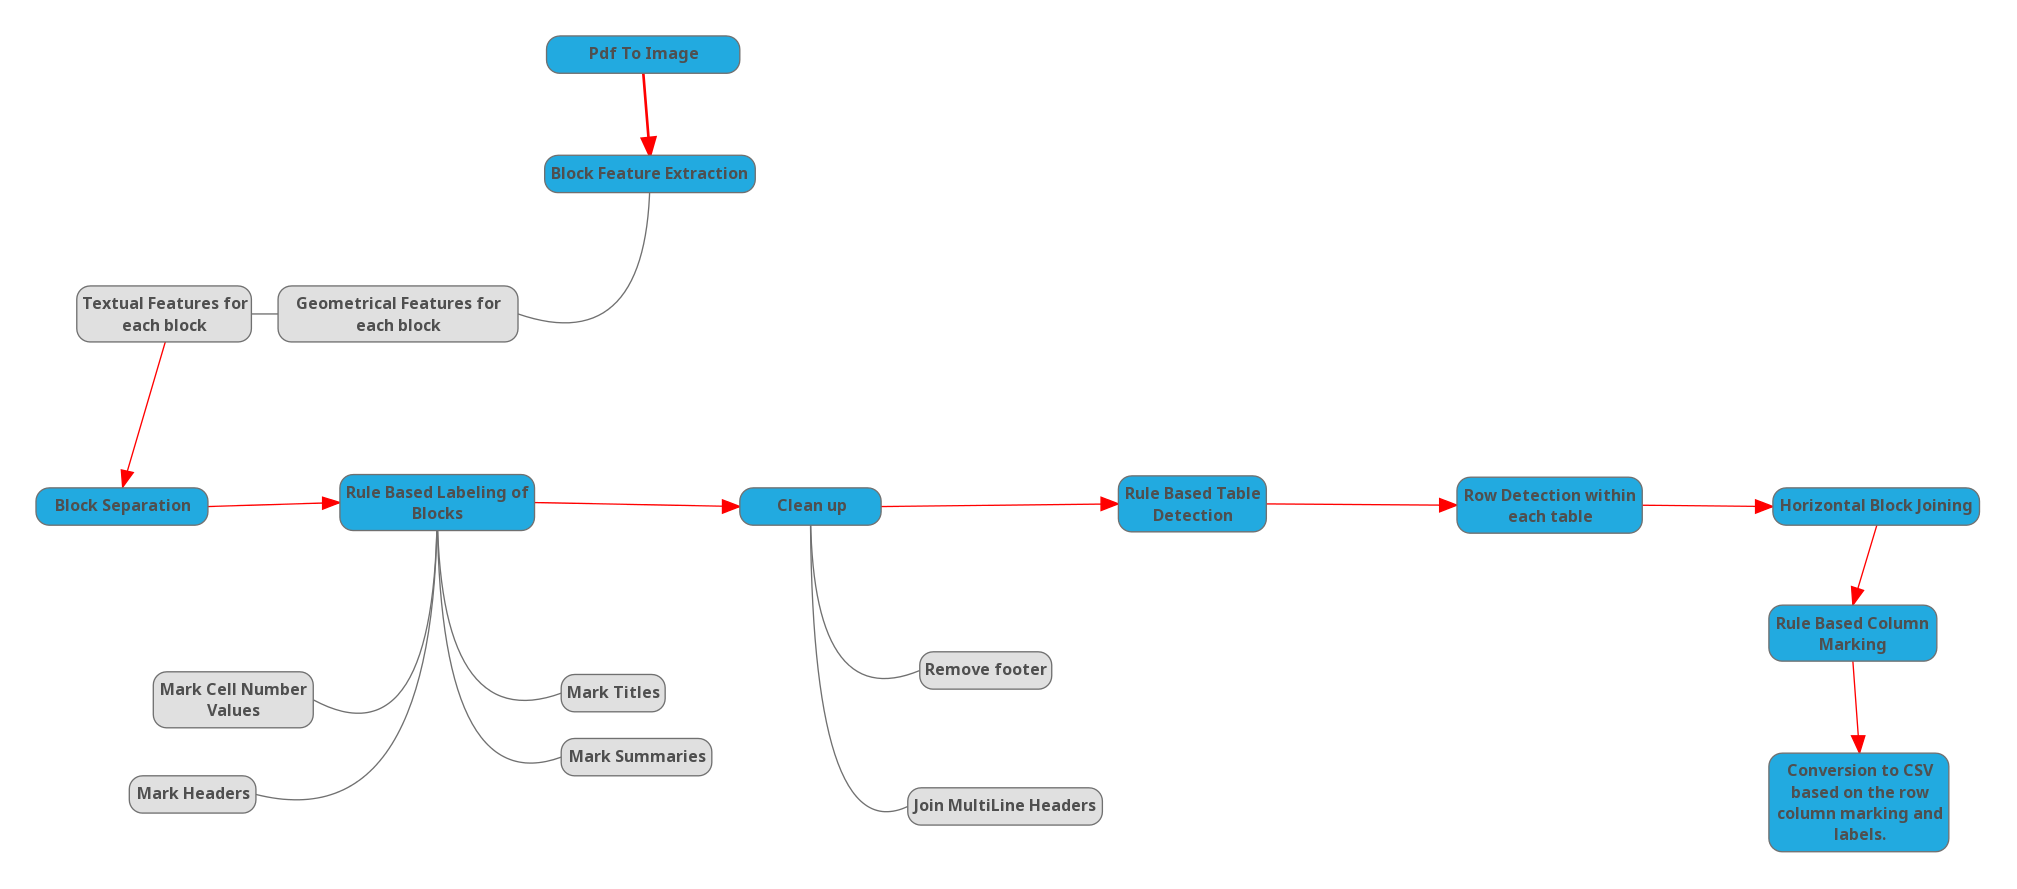

In [2]:
Image(filename='block_pdf_img_to_csv.png')

The Algorithm is a mix of Feature engineering/extraction and rule based labeling of blocks, where blocks are defined as group of texts separated by whitespace.

The first step to the algorithm is Block generation itself. We use an algorithm called [Run Length Smoothing Algorithm (RLSA)](#RLSA). 




After getting the blocks with generate two kinds of features : 

    - Geometrical features using `connectedComponentsWithStats` from [OpenCV](http://opencv.org/).
      This gives us features like: 
        - Left most point
        - Top most point
        - Height
        - Width etc.
    - Text Based Features, the text within each block is extracted using pdftotext from `poppler-0.57.0`
      https://poppler.freedesktop.org/. Using the text we generate textual features like:
        - Text Length
        - "is_text", defining whether the block contains numbers or text only.
        - "possible_row_merger", we detect if there is a possibilty of rows being merged in a block. 
          Its easily detected if the text has the new like character `\n`
        and more.
        

In [7]:
# Lets Load an image first.

def get_page_image_from_pdf(pdf, page_num, image_file_name):
    page_layout = pdf.getPage(page_num)['/MediaBox']
    command = "convert -density 300 '%s'[%s] '%s'" % (pdf_file_path,
                                                      page_num,
                                                      image_file_name)
    subprocess.check_output(command, shell=True)
    return cv2.imread(image_file_name, 0)

def plot_page(img):
    plt.figure(figsize=(30,20))
    plt.imshow(img, cmap='gray')

pdf_file_path = 'pdfs/west bengal/2017-18/2017_bp11_Demand Nos.1-5.pdf'
pdf = PdfFileReader(open(pdf_file_path, 'rb'))
page_layout = pdf.getPage(3)['/MediaBox']
if '/Rotate' in pdf.getPage(3) and pdf.getPage(3)['/Rotate'] == 90:
    page_width = float(page_layout[3])
    page_height = float(page_layout[2])
else:
    page_width = float(page_layout[2])
    page_height = float(page_layout[3])
img_page = get_page_image_from_pdf(pdf, 2, 'west_bengal_demand_1_5_page_1.png')
image_height, image_width = img_page.shape
horizontal_ratio = page_width / image_width
vertical_ratio = page_height / image_height


In [27]:
class BaseFeatureExtractor(object):
    '''A base class to extract features.
    '''
    def __init__(self):
        '''Placeholder.
        '''
        pass
    
    def extract(self):
        '''To be defined while extending.
        '''
        raise NotImplementedError("Function not implemented in BaseClass")


class GeometricalFeatureExtractor(BaseFeatureExtractor):
    '''Extract geometrical feature for each block.
    
    Args:
        - img_with_blocks (obj:`numpy.Array`): Image processed using RLSA or 
            any other similar algo.
    
    Returns:
        A dataframe with blocks and its geometrical features in each row.
    '''
    def __init__(self, img_with_blocks):
        self.img_with_blocks = img_with_blocks
    
    @staticmethod
    def get_block_stats_df(stats):
        '''Convert stats from cv2.connectedComponentsWithStats to dataframe.
        
        Args:
            - stats (obj:`numpy.Array`): the stats generated from openCV
        
        Returns:
            A dataframe with stats
        '''
        stats_columns = ["left", "top", "width", "height", "area"]
        block_stats = pd.DataFrame(stats, columns=stats_columns)
        # Ignore the label 0 since it is the background
        block_stats.drop(0, inplace=True)
        return block_stats
    
    def extract(self):
        '''Extract Geometrical features from img with blocks.
        
        Returns:
            A dataframe with each row as block and its geom features.
        '''
        _, _, stats, _ = cv2.connectedComponentsWithStats(self.img_with_blocks)
        block_stats = self.get_block_stats_df(stats)
        block_stats['right'] = block_stats.left + block_stats.width
        block_stats['bottom'] = block_stats.top + block_stats.height
        block_stats['pos'] = block_stats.index
        return block_stats
    
class TextualFeatureExtractor(BaseFeatureExtractor):
    '''Extract Textual Features of each block.
    
    Args:
        - blocks_stats (obj:`pd.DataFrame`): The blocks dataframe generated from
            `GeometricalFeatureExtractor`.
        - img (obj:`numpy.Array`): Matrix form of the image.
        - horizontal_ratio (float): ratio of page_width and image_width.
        - vertical_ratio (float): ratio of page_height and image_height.
        - page_num (int): Page number from where to read the text.
        - pdf_file_path (string): Path of the pdf file.
    '''
    def __init__(self, block_stats, img, horizontal_ratio,
                 vertical_ratio, pdf_file_path, page_num):
        self.block_stats = block_stats
        self.img = img
        # these are required for scaling boundaries while reading text.
        self.horizontal_ratio = horizontal_ratio
        self.vertical_ratio = vertical_ratio
        # since we use an external command to extract text we need 
        # to have some pdf information also.
        self.pdf_file_path = pdf_file_path
        self.page_num = page_num
    
    def get_text_from_pdf(self, x, y, w, h):
        cmd_ext = 'pdftotext'
        cmd_page_params = ' -f {0} -l {0}'.format(self.page_num + 1)
        cmd_tail = ' -x {0} -y {1} -W {2} -H {3} "{4}" -'.format(int(x), 
                                                                 int(y),
                                                                 int(w),
                                                                 int(h),
                                                                 self.pdf_file_path)
        command = cmd_ext + cmd_page_params + cmd_tail
        return subprocess.check_output(command, shell=True)
    
    def generate_text_data(self, row):
        '''Generate Text features for a given block.
        '''
        x = (row['left'] * self.horizontal_ratio)
        y = (row['top'] * self.vertical_ratio)
        width = (row['width'] * self.horizontal_ratio) + 5
        hieght = (row['height'] * self.vertical_ratio) + 5
        text = self.get_text_from_pdf(x, y, width, hieght)
        if len(text.strip().replace('-','')) < 1:
            row['text'] = text.strip().replace('-','')
        else:
            row['text'] = text.strip()
        row['text_length'] = len(row['text'])
        row['possible_row_merger'] = '\n' in row['text']
        text_matched = re.findall('[a-zA-Z_]+', row['text'])
        comma_sep_matcher = re.compile('^[1-9].(,[0-9]).*$')
        if comma_sep_matcher.match(row['text'].replace('\n', ' ')):
            row['comma_separated_numbers_present'] = True
        else:
            row['comma_separated_numbers_present'] = False
        if len(text_matched) > 0:
            row['is_text'] = True
        else:
            row['is_text'] = False

        try:
            row['number'] = int(row['text'].replace(',',''))
        except:
            row['number'] = None
        return row
    
    def extract(self):
        '''Extract text based features from each block.
        
        Returns:
            A Dataframe with each row as block and text based features.
        '''
        return self.block_stats.apply(self.generate_text_data, axis=1)
        

class BlockFeatureGenerator(object):
    '''Convert a pdf page image with text on it to blocks.
    
    Args:
        - img (obj:`numpy.Array`): Matrix form of the image.
        - horizontal_ratio (float): ratio of page_width and image_width.
        - vertical_ratio (float): ratio of page_height and image_height.
        - page_num (int): Page number from where to read the text.
        - pdf_file_path (string): Path of the pdf file.
        - block_threshold (tuple:(int, int)): A tuple containing threshold params
            namely vertical and horizontal for block generation.
    '''
    def __init__(self, img, horizontal_ratio, vertical_ratio,
                 pdf_file_path, page_num, block_threshold):
        self.img = img
        self.horizontal_ratio = horizontal_ratio
        self.vertical_ratio = vertical_ratio
        self.pdf_file_path = pdf_file_path
        self.page_num = page_num
        self.block_threshold = block_threshold
        
    @staticmethod
    def generate_blocks(img, threshold):
        ret,thresh1 = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY_INV)
        img_iter = np.nditer(thresh1, flags=['multi_index'])
        C_vertical, C_horizontal = threshold
        temp_thresh = thresh1.copy()
        while not img_iter.finished:
            x, y = img_iter.multi_index
            x_threshold = x + C_horizontal
            y_threshold = y + C_vertical
            neg_x_threshold = x - C_horizontal
            neg_y_threshold = y - C_vertical
            if (thresh1[x:x_threshold, y:y_threshold].any() 
                or thresh1[x:x_threshold, y:neg_y_threshold].any()
                or thresh1[x:neg_x_threshold, y:y_threshold].any()
                or thresh1[x:neg_x_threshold, y:neg_y_threshold].any()):
                temp_thresh[x, y] = 1
            else:
                temp_thresh[x, y] = 0
            img_iter.iternext()
        return temp_thresh
        
    def generate(self):
        '''Generate geometrical and textual features of block within an image. 
        
        Returns:
            A dataframe containing geometrical and textual features.
        '''
        img_with_blocks = self.generate_blocks(self.img, self.block_threshold)
        block_stats = GeometricalFeatureExtractor(img_with_blocks).extract()
        block_stats_with_text_data = TextualFeatureExtractor(block_stats, self.img, 
                                                             self.horizontal_ratio,
                                                             self.vertical_ratio,
                                                             self.page_num,
                                                             self.pdf_file_path).extract()
        return block_stats_with_text_data

In [28]:
feature_extractor = BlockFeatureGenerator(img_page, horizontal_ratio, vertical_ratio, 2, pdf_file_path, (20,25))
block_features = feature_extractor.generate()

In [29]:
block_features.head()

,left,top,width,height,area,right,bottom,pos,text,text_length,possible_row_merger,comma_separated_numbers_present,is_text,number
1,0,0,20,25,500,20,25,1,,0,False,False,False,NaN
2,135,0,2183,25,54575,2318,25,2,,0,False,False,False,NaN
3,0,103,20,62,1240,20,165,3,,0,False,False,False,NaN
4,885,103,690,62,42076,1575,165,4,REVENUE EXPENDITURE,19,False,False,True,NaN
5,0,177,20,57,1140,20,234,5,,0,False,False,False,NaN


Post Getting our Features we do some cleaning up:
    
    - Remove Blocks that don't hold any information
    - Modify some of the blocks, seprate the blocks where there is a possbile merger detected. 
    

Do column separation post getting alignment from each row

Possible Solution

    - Group rows by number of blocks
    - Sort by frequency
    - Calculate alignment for each block based on voting.
    
    
    
Do Feature Extraction from titles to generate names for csv file
Use the naming structure to combine csv files.
The Goal is for west bengal Demand No and Head is unique and each csv file should be unique with respect to it.

Handle Tables without headers.

Exclude tables with voted charged summaries

---------------------------

## Glossary

#### RLSA
The Run Length Smoothing Algorithm (RLSA) is a method that can be used for Block segmentation and text discrimination. The method developed for the Document Analysis System consists of two steps. First, a segmentation procedure subdivides the area of a document into regions (blocks), each of which should contain only one type of data (text, graphic, halftone image, etc.). Next, some basic features of these blocks are calculated.

The basic RLSA is applied to a binary sequence in which white pixels are represented by 0’s and black pixels by 1’s. The algorithm transforms a binary sequence x into an output sequence y according to the following rules:

    0’s in x are changed to 1’s in y if the number of adjacent 0’s is less than or equal to a predefined limit C.
    1’s in x are unchanged in y .

For example, with C = 4 the sequence x is mapped into y as follows:

    x : 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0
    y : 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1